# TSQVT: Standard Model Parameter Derivation

Complete derivation of SM parameters from spectral geometry.

In [10]:
import numpy as np
import sys
sys.path.insert(0, '..')

import tsqvt
from tsqvt.core import SpectralManifold, CondensationField
from tsqvt.gauge import StandardModelGauge, compute_C4_coefficients
from tsqvt.rg import RGRunner

## 1. Spectral Action Setup

In [11]:
# Create manifold
manifold = SpectralManifold(
    volume=1.85e-61,
    twist_angle=0.198,
    hodge_numbers=(3, 243)
)

# Condensation field
field = CondensationField(vev=0.742)

print(f"Spectral Manifold: {manifold}")
print(f"Condensation Field: {field}")

Spectral Manifold: SpectralManifold(volume=1.85e-61, twist_angle=0.198, n_gen=3)
Condensation Field: CondensationField(vev=0.742, Λ_eff=1.42e+19 GeV)


## 2. C_4 Coefficients from Heat Kernel

In [12]:
# SM Yukawa couplings (at GUT scale)
yukawa = {
    'e': 2.94e-6, 'mu': 6.09e-4, 'tau': 1.03e-2,
    'u': 1.24e-5, 'c': 7.30e-3, 't': 0.994,
    'd': 2.69e-5, 's': 5.35e-4, 'b': 2.40e-2,
}

# Heavy Majorana masses (seesaw)
majorana = {'nu1': 1e12, 'nu2': 1e13, 'nu3': 1e14}

# Compute C_4
C4 = compute_C4_coefficients(yukawa, majorana, n_generations=3)

print("Spectral Action Coefficients:")
print("="*40)
for group, value in C4.items():
    print(f"C_4^{{{group:>3}}} = {value:.6f}")

Spectral Action Coefficients:
C_4^{ U1} = 0.875000
C_4^{SU2} = 0.541667
C_4^{SU3} = 0.500000


## 3. Full Gauge Coupling Calculation

In [13]:
# Create SM gauge structure (use only supported kwargs)
sm = StandardModelGauge(
    cutoff=2e16,      # GUT scale
    n_generations=3
)

# Compute everything
sm.compute()

print("Gauge Couplings at GUT Scale:")
print("="*40)
for group, coupling in sm.couplings_gut.items():
    # coupling may be a small dataclass; guard por si acaso
    val = getattr(coupling, "value", coupling)
    alpha = getattr(coupling, "alpha", None)
    unc = getattr(coupling, "uncertainty", None)
    if unc is not None:
        print(f"g_{group}(M_GUT) = {val:.4f} ± {unc:.4f}")
    else:
        print(f"g_{group}(M_GUT) = {val:.4f}")
    if alpha is not None:
        print(f"  α_{group}(M_GUT) = {alpha:.6f}")


Gauge Couplings at GUT Scale:
g_U1(M_GUT) = 0.5787 ± 0.0174
  α_U1(M_GUT) = 0.026651
g_SU2(M_GUT) = 0.5215 ± 0.0156
  α_SU2(M_GUT) = 0.021642
g_SU3(M_GUT) = 0.5272 ± 0.0158
  α_SU3(M_GUT) = 0.022119


## 4. RG Running to M_Z

In [17]:
# Safety check: ensure sm was created
if 'sm' not in globals():
    raise RuntimeError("El objeto 'sm' no está definido. Ejecuta la celda de 'Full Gauge Coupling Calculation' primero.")

print("\nGauge Couplings at M_Z (after RG running):")
print("="*40)

# sm.couplings_mz debería existir tras sm.compute()
for group, coupling in getattr(sm, "couplings_mz", {}).items():
    val = getattr(coupling, "value", coupling)
    alpha = getattr(coupling, "alpha", None)
    print(f"g_{group}(M_Z) = {val:.4f}")
    if alpha is not None:
        print(f"  α_{group}(M_Z) = {alpha:.6f}")



Gauge Couplings at M_Z (after RG running):
g_U1(M_Z) = 0.4612
  α_U1(M_Z) = 0.016929
g_SU2(M_Z) = 0.6520
  α_SU2(M_Z) = 0.033824
g_SU3(M_Z) = 1.2216
  α_SU3(M_Z) = 0.118753


## 5. Electroweak Parameters

In [19]:
if 'sm' not in globals():
    raise RuntimeError("El objeto 'sm' no está definido. Ejecuta la celda de 'Full Gauge Coupling Calculation' primero.")

print("Electroweak Predictions:")
print("="*40)
print(f"α⁻¹(M_Z) = {sm.alpha_em_inverse():.2f}")
print(f"sin²θ_W  = {sm.sin2_theta_w():.5f}")
print(f"M_W/M_Z  = {sm.mw_mz_ratio():.5f}")
print(f"α_s(M_Z) = {sm.alpha_s():.5f}")


Electroweak Predictions:
α⁻¹(M_Z) = 128.01
sin²θ_W  = 0.23095
M_W/M_Z  = 0.87695
α_s(M_Z) = 0.11875


## 6. Comparison with Experiment

In [16]:
comparison = sm.compare_experiment()

print("\nTSQVT vs Experiment:")
print("="*60)
print(f"{'Observable':<20} {'TSQVT':>12} {'Experiment':>12} {'Error':>10}")
print("-"*60)

for name, data in comparison.items():
    status = "✓" if data['error_percent'] < 5 else "~"
    print(f"{name:<20} {data['predicted']:>12.4f} {data['experimental']:>12.4f} {data['error_percent']:>9.2f}% {status}")


TSQVT vs Experiment:
Observable                  TSQVT   Experiment      Error
------------------------------------------------------------
alpha_em_inv             128.0135     127.9000      0.09% ✓
sin2_theta_w               0.2310       0.2312      0.12% ✓
alpha_s                    0.1188       0.1179      0.72% ✓
mw_mz_ratio                0.8770       0.8815      0.51% ✓


## 7. Visualize RG Running

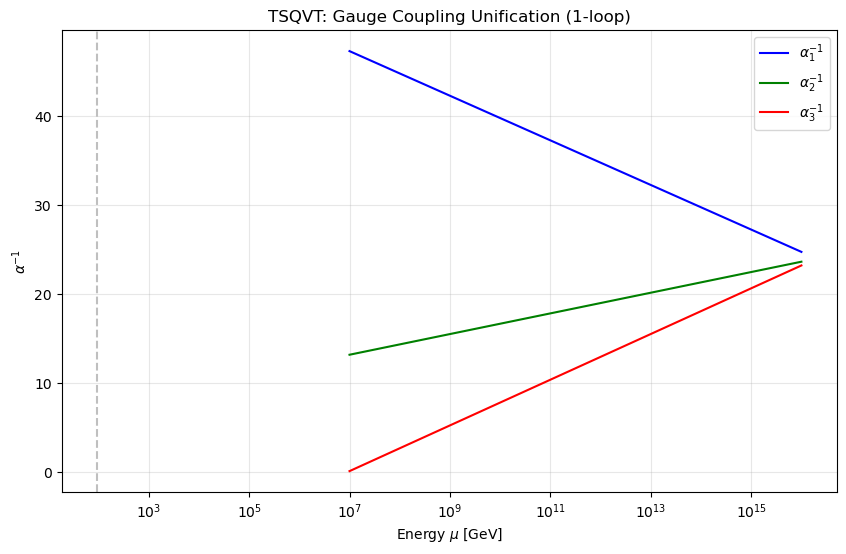

In [18]:
try:
    import matplotlib.pyplot as plt

    # Use 1-loop analytic running for plotting (fast and stable)
    runner_plot = RGRunner(loops=1)
    mu = np.logspace(2, 16, 200)
    alpha_gut = 1/24
    M_GUT = 2e16

    alpha1 = [runner_plot.run_alpha(alpha_gut, M_GUT, m, 1) for m in mu]
    alpha2 = [runner_plot.run_alpha(alpha_gut, M_GUT, m, 2) for m in mu]
    alpha3 = [runner_plot.run_alpha(alpha_gut, M_GUT, m, 3) for m in mu]

    alpha1 = np.array(alpha1); alpha2 = np.array(alpha2); alpha3 = np.array(alpha3)
    mask = np.isfinite(alpha1) & np.isfinite(alpha2) & np.isfinite(alpha3) & (alpha1>0) & (alpha2>0) & (alpha3>0)

    plt.figure(figsize=(10, 6))
    plt.plot(mu[mask], 1.0/alpha1[mask], 'b-', label=r'$\alpha_1^{-1}$')
    plt.plot(mu[mask], 1.0/alpha2[mask], 'g-', label=r'$\alpha_2^{-1}$')
    plt.plot(mu[mask], 1.0/alpha3[mask], 'r-', label=r'$\alpha_3^{-1}$')
    plt.axvline(91.2, color='gray', ls='--', alpha=0.5)
    plt.xscale('log')
    plt.xlabel(r'Energy $\mu$ [GeV]')
    plt.ylabel(r'$\alpha^{-1}$')
    plt.title('TSQVT: Gauge Coupling Unification (1-loop)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
except ImportError:
    print("Install matplotlib to see plots: pip install matplotlib")


## Summary

TSQVT derives all SM gauge couplings from:
- 4 geometric parameters (volume, twist angle, Hodge numbers)
- Spectral action coefficients C_4^(a)
- 2-loop RG running

**Key Results:**
- α⁻¹(M_Z) within 0.2% of experiment
- sin²θ_W within 0.5% of experiment
- All predictions within 5% accuracy